In [48]:
import os
import random
SEED_NUMBER = 1998

random.seed(SEED_NUMBER)

def parse_annotation(annotation_file_path, shuffle=False):
    with open(annotation_file_path, "rt") as file:
        lines = [line.replace("\n", "") for line in file.readlines()]
        image_label = [[line.split(" ")[0], line.split(" ")[2]] for line in lines]
    if shuffle:
        random.shuffle(image_label)
    return image_label


TRAINVAL_ANNOTATION_TXT = os.path.join(
    "dataset", "pet", "annotations", "trainval.txt"
)
trainval_label = parse_annotation(TRAINVAL_ANNOTATION_TXT, shuffle=True)
trainval_label

[['miniature_pinscher_119', '2'],
 ['chihuahua_164', '2'],
 ['Russian_Blue_139', '1'],
 ['basset_hound_172', '2'],
 ['english_setter_158', '2'],
 ['Russian_Blue_16', '1'],
 ['german_shorthaired_167', '2'],
 ['miniature_pinscher_151', '2'],
 ['german_shorthaired_119', '2'],
 ['miniature_pinscher_188', '2'],
 ['saint_bernard_100', '2'],
 ['german_shorthaired_170', '2'],
 ['Ragdoll_159', '1'],
 ['english_setter_137', '2'],
 ['Maine_Coon_205', '1'],
 ['leonberger_155', '2'],
 ['english_cocker_spaniel_102', '2'],
 ['British_Shorthair_163', '1'],
 ['British_Shorthair_114', '1'],
 ['pomeranian_168', '2'],
 ['Ragdoll_190', '1'],
 ['great_pyrenees_100', '2'],
 ['american_pit_bull_terrier_187', '2'],
 ['japanese_chin_108', '2'],
 ['Ragdoll_174', '1'],
 ['english_setter_153', '2'],
 ['Egyptian_Mau_155', '1'],
 ['Sphynx_125', '1'],
 ['Bombay_13', '1'],
 ['german_shorthaired_179', '2'],
 ['boxer_179', '2'],
 ['scottish_terrier_119', '2'],
 ['german_shorthaired_160', '2'],
 ['great_pyrenees_173', '2

In [49]:
boundary = int(len(trainval_label) * 0.8)
train_label = trainval_label[:boundary]
validation_label = trainval_label[boundary:]
print(len(trainval_label))
print(len(train_label))
print(len(validation_label))

3680
2944
736


data.shape (200, 200, 3)
label.shape (200, 200)
1    28871
0     6402
2     4727
dtype: int64
1


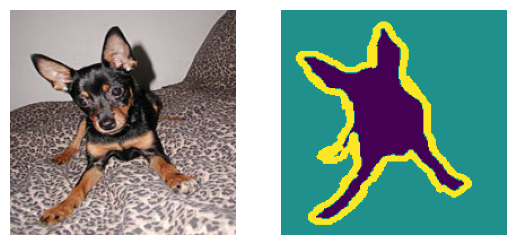

In [50]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np


ANNOTATION_DIR = os.path.join("dataset", "pet", "annotations", "trimaps")
TRAIN_DIR = os.path.join("dataset", "pet", "images")
ANNOTATION_EXTENSION = ".png"
TRAIN_EXTENSION = ".jpg"
IMAGE_SIZE = (200, 200)


def image_dataset_generator(filename_to_label):
    for filename, label in filename_to_label:
        yield (
            np.asarray(
                Image.open(os.path.join(TRAIN_DIR, filename + TRAIN_EXTENSION))
                .resize(IMAGE_SIZE)
                .convert("RGB")
            ),
            (np.asarray(
                Image.open(
                    os.path.join(ANNOTATION_DIR, filename + ANNOTATION_EXTENSION)
                ).resize(IMAGE_SIZE)
            )
            - 1, int(label)-1),
        )


import pandas as pd


for data, labels in image_dataset_generator(trainval_label):
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(data)
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.imshow(labels[0])
    print("data.shape", data.shape)
    print("label.shape", labels[0].shape)
    print(pd.Series(labels[0].flatten()).value_counts())
    print(labels[1])
    break


In [51]:
import tensorflow as tf
import numpy as np

def get_dataset(filename_to_label, output_signature):
    return tf.data.Dataset.from_generator(
        lambda :image_dataset_generator(filename_to_label),
        output_signature=output_signature,
    )

output_signature = (
    tf.TensorSpec(shape=(*IMAGE_SIZE, 3)),
    (tf.TensorSpec(shape=IMAGE_SIZE, dtype=tf.int32), tf.TensorSpec(shape=None, dtype=tf.int32)),
)


train_dataset = get_dataset(
    train_label, output_signature
)
validation_dataset = get_dataset(
    validation_label, output_signature
)
train_dataset


<FlatMapDataset element_spec=(TensorSpec(shape=(200, 200, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(200, 200), dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None)))>

In [52]:
def get_model(img_size: tuple, num_classes: int):
    input_tensor = tf.keras.Input((*img_size, 3))
    # Preprocessing stage
    x = tf.keras.layers.Rescaling(1.0 / 255)(input_tensor)
    # Encoding stage
    x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    encoding_out = tf.keras.layers.ReLU()(x)
    # Decoding stage
    x = tf.keras.layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(
        encoding_out
    )
    x = tf.keras.layers.Conv2DTranspose(
        256, 3, strides=2, activation="relu", padding="same"
    )(x)
    x = tf.keras.layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(
        128, 3, strides=2, activation="relu", padding="same"
    )(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(
        64, 3, strides=2, activation="relu", padding="same"
    )(x)
    # Segmenting stage
    seg_out = tf.keras.layers.Conv2D(
        num_classes, 3, activation="softmax", padding="same", name="seg"
    )(x)
    # Classification stage
    y = tf.keras.layers.Flatten()(encoding_out)
    y = tf.keras.layers.Dense(256, use_bias=False)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.ReLU()(y)
    clf_out = tf.keras.layers.Dense(1, activation="sigmoid", name="clf")(y)
    return tf.keras.Model(inputs=[input_tensor], outputs=[seg_out, clf_out])


model = get_model(IMAGE_SIZE, 3)
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 200, 200, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 100, 100, 64  1728        ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                            

In [53]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=[
        tf.keras.losses.SparseCategoricalCrossentropy(),
        tf.keras.losses.BinaryCrossentropy(),
    ],
    loss_weights=[0.8, 0.2],
    metrics=[[tf.keras.metrics.SparseCategoricalCrossentropy()], [tf.keras.metrics.BinaryAccuracy()]]
)


In [54]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("", save_best_only=True)
]

In [55]:
history = model.fit(
    train_dataset.shuffle(4096).repeat(1).batch(32),
    epochs=70,
    validation_data=validation_dataset.repeat(1).batch(32),
    callbacks=callbacks
)


Epoch 1/70


2022-10-26 11:27:43.706062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1376 of 4096
2022-10-26 11:27:53.703423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2638 of 4096
2022-10-26 11:27:56.070389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


     92/Unknown - 39s 156ms/step - loss: 0.8667 - seg_loss: 0.8914 - clf_loss: 0.7678 - seg_sparse_categorical_crossentropy: 0.8914 - clf_binary_accuracy: 0.6202

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


92/92 [==============================] - 52s 291ms/step - loss: 0.8667 - seg_loss: 0.8914 - clf_loss: 0.7678 - seg_sparse_categorical_crossentropy: 0.8914 - clf_binary_accuracy: 0.6202 - val_loss: 0.9902 - val_seg_loss: 1.0359 - val_clf_loss: 0.8073 - val_seg_sparse_categorical_crossentropy: 1.0359 - val_clf_binary_accuracy: 0.3315
Epoch 2/70


2022-10-26 11:28:33.036676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1356 of 4096
2022-10-26 11:28:43.039711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2568 of 4096
2022-10-26 11:28:46.010910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - ETA: 0s - loss: 0.7024 - seg_loss: 0.7229 - clf_loss: 0.6203 - seg_sparse_categorical_crossentropy: 0.7229 - clf_binary_accuracy: 0.6715

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


92/92 [==============================] - 49s 279ms/step - loss: 0.7024 - seg_loss: 0.7229 - clf_loss: 0.6203 - seg_sparse_categorical_crossentropy: 0.7229 - clf_binary_accuracy: 0.6715 - val_loss: 0.7335 - val_seg_loss: 0.7689 - val_clf_loss: 0.5916 - val_seg_sparse_categorical_crossentropy: 0.7689 - val_clf_binary_accuracy: 0.6726
Epoch 3/70


2022-10-26 11:29:21.962159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1352 of 4096
2022-10-26 11:29:31.961803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2589 of 4096
2022-10-26 11:29:34.733295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 45s 237ms/step - loss: 0.6178 - seg_loss: 0.6336 - clf_loss: 0.5545 - seg_sparse_categorical_crossentropy: 0.6336 - clf_binary_accuracy: 0.7181 - val_loss: 0.9659 - val_seg_loss: 0.9538 - val_clf_loss: 1.0142 - val_seg_sparse_categorical_crossentropy: 0.9538 - val_clf_binary_accuracy: 0.3573
Epoch 4/70


2022-10-26 11:30:06.752572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1341 of 4096
2022-10-26 11:30:16.756075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2581 of 4096
2022-10-26 11:30:19.607781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - ETA: 0s - loss: 0.5493 - seg_loss: 0.5715 - clf_loss: 0.4603 - seg_sparse_categorical_crossentropy: 0.5715 - clf_binary_accuracy: 0.7870

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


92/92 [==============================] - 49s 284ms/step - loss: 0.5493 - seg_loss: 0.5715 - clf_loss: 0.4603 - seg_sparse_categorical_crossentropy: 0.5715 - clf_binary_accuracy: 0.7870 - val_loss: 0.6923 - val_seg_loss: 0.6508 - val_clf_loss: 0.8582 - val_seg_sparse_categorical_crossentropy: 0.6508 - val_clf_binary_accuracy: 0.4701
Epoch 5/70


2022-10-26 11:30:55.961535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1365 of 4096
2022-10-26 11:31:05.964126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2623 of 4096
2022-10-26 11:31:08.441889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - ETA: 0s - loss: 0.5024 - seg_loss: 0.5394 - clf_loss: 0.3544 - seg_sparse_categorical_crossentropy: 0.5394 - clf_binary_accuracy: 0.8438

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


92/92 [==============================] - 49s 281ms/step - loss: 0.5024 - seg_loss: 0.5394 - clf_loss: 0.3544 - seg_sparse_categorical_crossentropy: 0.5394 - clf_binary_accuracy: 0.8438 - val_loss: 0.5859 - val_seg_loss: 0.6005 - val_clf_loss: 0.5272 - val_seg_sparse_categorical_crossentropy: 0.6005 - val_clf_binary_accuracy: 0.7459
Epoch 6/70


2022-10-26 11:31:44.632665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1348 of 4096
2022-10-26 11:31:54.631760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2586 of 4096
2022-10-26 11:31:57.430465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 45s 237ms/step - loss: 0.4579 - seg_loss: 0.5128 - clf_loss: 0.2382 - seg_sparse_categorical_crossentropy: 0.5128 - clf_binary_accuracy: 0.9032 - val_loss: 0.5968 - val_seg_loss: 0.5768 - val_clf_loss: 0.6769 - val_seg_sparse_categorical_crossentropy: 0.5768 - val_clf_binary_accuracy: 0.7541
Epoch 7/70


2022-10-26 11:32:29.431504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1373 of 4096
2022-10-26 11:32:39.435055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2618 of 4096
2022-10-26 11:32:41.950211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 45s 237ms/step - loss: 0.4223 - seg_loss: 0.4914 - clf_loss: 0.1456 - seg_sparse_categorical_crossentropy: 0.4914 - clf_binary_accuracy: 0.9494 - val_loss: 0.6497 - val_seg_loss: 0.5800 - val_clf_loss: 0.9287 - val_seg_sparse_categorical_crossentropy: 0.5800 - val_clf_binary_accuracy: 0.7622
Epoch 8/70


2022-10-26 11:33:14.064701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1355 of 4096
2022-10-26 11:33:24.063552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2588 of 4096
2022-10-26 11:33:26.859631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 45s 237ms/step - loss: 0.3970 - seg_loss: 0.4742 - clf_loss: 0.0881 - seg_sparse_categorical_crossentropy: 0.4742 - clf_binary_accuracy: 0.9688 - val_loss: 0.5993 - val_seg_loss: 0.4719 - val_clf_loss: 1.1087 - val_seg_sparse_categorical_crossentropy: 0.4719 - val_clf_binary_accuracy: 0.7785
Epoch 9/70


2022-10-26 11:33:58.919029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1357 of 4096
2022-10-26 11:34:08.921507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2600 of 4096
2022-10-26 11:34:11.639280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 45s 237ms/step - loss: 0.3814 - seg_loss: 0.4620 - clf_loss: 0.0590 - seg_sparse_categorical_crossentropy: 0.4620 - clf_binary_accuracy: 0.9806 - val_loss: 0.6559 - val_seg_loss: 0.5465 - val_clf_loss: 1.0933 - val_seg_sparse_categorical_crossentropy: 0.5465 - val_clf_binary_accuracy: 0.7690
Epoch 10/70


2022-10-26 11:34:43.755643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1366 of 4096
2022-10-26 11:34:53.753556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2604 of 4096
2022-10-26 11:34:56.412328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - ETA: 0s - loss: 0.3656 - seg_loss: 0.4432 - clf_loss: 0.0550 - seg_sparse_categorical_crossentropy: 0.4432 - clf_binary_accuracy: 0.9793

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


92/92 [==============================] - 49s 284ms/step - loss: 0.3656 - seg_loss: 0.4432 - clf_loss: 0.0550 - seg_sparse_categorical_crossentropy: 0.4432 - clf_binary_accuracy: 0.9793 - val_loss: 0.5537 - val_seg_loss: 0.4503 - val_clf_loss: 0.9674 - val_seg_sparse_categorical_crossentropy: 0.4503 - val_clf_binary_accuracy: 0.7622
Epoch 11/70


2022-10-26 11:35:32.697571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1371 of 4096
2022-10-26 11:35:42.703033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2602 of 4096
2022-10-26 11:35:45.394998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 45s 237ms/step - loss: 0.3559 - seg_loss: 0.4319 - clf_loss: 0.0516 - seg_sparse_categorical_crossentropy: 0.4319 - clf_binary_accuracy: 0.9827 - val_loss: 0.8391 - val_seg_loss: 0.4656 - val_clf_loss: 2.3328 - val_seg_sparse_categorical_crossentropy: 0.4656 - val_clf_binary_accuracy: 0.7527
Epoch 12/70


2022-10-26 11:36:17.520028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1369 of 4096
2022-10-26 11:36:27.525610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2605 of 4096
2022-10-26 11:36:30.165349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 45s 237ms/step - loss: 0.3415 - seg_loss: 0.4178 - clf_loss: 0.0361 - seg_sparse_categorical_crossentropy: 0.4178 - clf_binary_accuracy: 0.9895 - val_loss: 0.7301 - val_seg_loss: 0.5339 - val_clf_loss: 1.5148 - val_seg_sparse_categorical_crossentropy: 0.5339 - val_clf_binary_accuracy: 0.7378
Epoch 13/70


2022-10-26 11:37:02.269978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1355 of 4096
2022-10-26 11:37:12.268765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2614 of 4096
2022-10-26 11:37:14.794851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 44s 236ms/step - loss: 0.3344 - seg_loss: 0.4116 - clf_loss: 0.0257 - seg_sparse_categorical_crossentropy: 0.4116 - clf_binary_accuracy: 0.9929 - val_loss: 0.7137 - val_seg_loss: 0.5393 - val_clf_loss: 1.4112 - val_seg_sparse_categorical_crossentropy: 0.5393 - val_clf_binary_accuracy: 0.7677
Epoch 14/70


2022-10-26 11:37:46.804067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1362 of 4096
2022-10-26 11:37:56.798624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2607 of 4096
2022-10-26 11:37:59.406279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 45s 237ms/step - loss: 0.3251 - seg_loss: 0.3986 - clf_loss: 0.0311 - seg_sparse_categorical_crossentropy: 0.3986 - clf_binary_accuracy: 0.9864 - val_loss: 0.7780 - val_seg_loss: 0.4844 - val_clf_loss: 1.9523 - val_seg_sparse_categorical_crossentropy: 0.4844 - val_clf_binary_accuracy: 0.7351
Epoch 15/70


2022-10-26 11:38:31.339500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1367 of 4096
2022-10-26 11:38:41.337618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2613 of 4096
2022-10-26 11:38:43.923651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 45s 237ms/step - loss: 0.3150 - seg_loss: 0.3884 - clf_loss: 0.0214 - seg_sparse_categorical_crossentropy: 0.3884 - clf_binary_accuracy: 0.9935 - val_loss: 0.5862 - val_seg_loss: 0.4090 - val_clf_loss: 1.2949 - val_seg_sparse_categorical_crossentropy: 0.4090 - val_clf_binary_accuracy: 0.7772
Epoch 16/70


2022-10-26 11:39:16.047829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1378 of 4096
2022-10-26 11:39:26.049191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2645 of 4096
2022-10-26 11:39:28.384215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 44s 237ms/step - loss: 0.3097 - seg_loss: 0.3793 - clf_loss: 0.0313 - seg_sparse_categorical_crossentropy: 0.3793 - clf_binary_accuracy: 0.9874 - val_loss: 0.7294 - val_seg_loss: 0.4510 - val_clf_loss: 1.8429 - val_seg_sparse_categorical_crossentropy: 0.4510 - val_clf_binary_accuracy: 0.7690
Epoch 17/70


2022-10-26 11:40:00.508779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1340 of 4096
2022-10-26 11:40:10.509261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2580 of 4096
2022-10-26 11:40:13.367669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 45s 238ms/step - loss: 0.2978 - seg_loss: 0.3676 - clf_loss: 0.0185 - seg_sparse_categorical_crossentropy: 0.3676 - clf_binary_accuracy: 0.9939 - val_loss: 0.6290 - val_seg_loss: 0.4217 - val_clf_loss: 1.4583 - val_seg_sparse_categorical_crossentropy: 0.4217 - val_clf_binary_accuracy: 0.7636


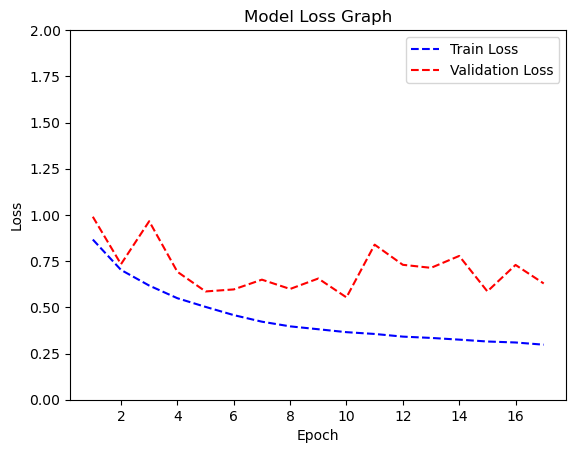

In [56]:
x_range = range(1, len(history.history["loss"]) + 1)
plt.plot(x_range, history.history["loss"], "b--", label="Train Loss")
plt.plot(x_range, history.history["val_loss"], "r--", label="Validation Loss")
plt.ylim((0, 2))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss Graph")
plt.legend()

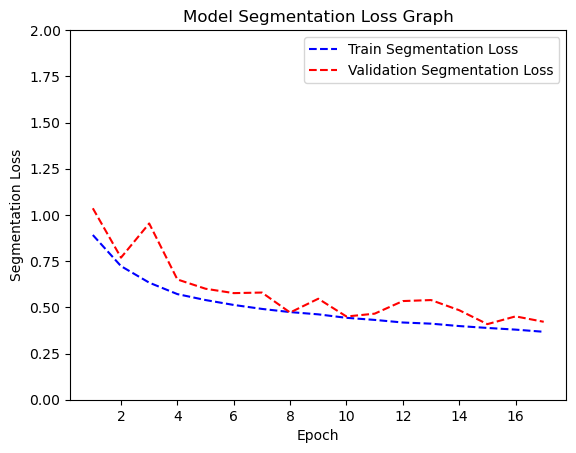

In [57]:
x_range = range(1, len(history.history["seg_loss"]) + 1)
plt.plot(x_range, history.history["seg_loss"], "b--", label="Train Segmentation Loss")
plt.plot(x_range, history.history["val_seg_loss"], "r--", label="Validation Segmentation Loss")
plt.ylim((0, 2))
plt.xlabel("Epoch")
plt.ylabel("Segmentation Loss")
plt.title("Model Segmentation Loss Graph")
plt.legend()

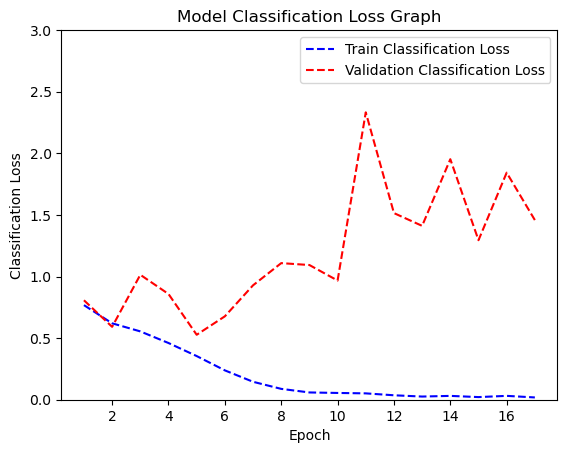

In [58]:
x_range = range(1, len(history.history["clf_loss"]) + 1)
plt.plot(x_range, history.history["clf_loss"], "b--", label="Train Classification Loss")
plt.plot(x_range, history.history["val_clf_loss"], "r--", label="Validation Classification Loss")
plt.ylim((0, 3))
plt.xlabel("Epoch")
plt.ylabel("Classification Loss")
plt.title("Model Classification Loss Graph")
plt.legend()

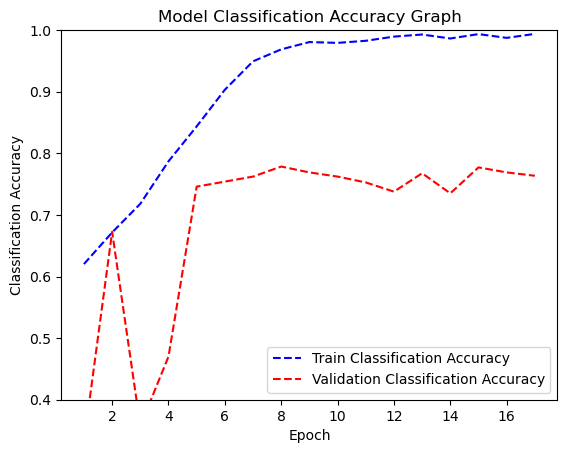

In [59]:
x_range = range(1, len(history.history["clf_binary_accuracy"]) + 1)
plt.plot(x_range, history.history["clf_binary_accuracy"], "b--", label="Train Classification Accuracy")
plt.plot(x_range, history.history["val_clf_binary_accuracy"], "r--", label="Validation Classification Accuracy")
plt.ylim((0.4, 1))
plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy")
plt.title("Model Classification Accuracy Graph")
plt.legend()